# Computer Vision Final - Spring 2023
#### FER-2013 dataset with Convolutional Block Attention Module


In [ ]:
import zipfile
from google.colab import drive
import torch
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from torch import nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Normalize, transforms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
drive.mount('/content/drive/')

cuda
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/ComputerVision/Emotion.zip", 'r')
zip_ref.extractall("/content/FER2013")
zip_ref.close()

In [ ]:
!ls FER2013/train


angry  disgust	fear  happy  neutral  sad  surprise


In [ ]:
! git clone https://github.com/Jongchan/attention-module.git

fatal: destination path 'attention-module' already exists and is not an empty directory.


In [ ]:
data_transform = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(),  transforms.Resize(256,antialias=True) ])

fer_2013 = datasets.ImageFolder(root='FER2013/train/',
                                           transform=data_transform)
train_load, dev_load = torch.utils.data.random_split(fer_2013, [25838, 2871])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_load,
                                             batch_size=128, shuffle=True,
                                             num_workers=2)
val_loader = torch.utils.data.DataLoader(dev_load,
                                             batch_size=128, shuffle=True,
                                             num_workers=2)
fer_2013_test = datasets.ImageFolder(root='FER2013/test/',
                                           transform=data_transform)
test_loader = torch.utils.data.DataLoader(fer_2013_test,
                                             batch_size=128, shuffle=True,
                                             num_workers=2)

In [ ]:
!python /content/attention-module/train_imagenet.py --ngpu 1 --arch resnet --depth 34 --epochs 30 --batch-size 256 --lr 0.1 --att-type CBAM --prefix RESNET50_IMAGENET_CBAM

  File "/content/attention-module/train_imagenet.py", line 181
    target = target.cuda(async=True)
                         ^^^^^
SyntaxError: invalid syntax


#### BAM Module

In [ ]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
class ChannelGate(nn.Module):
    def __init__(self, gate_channel, reduction_ratio=16, num_layers=1):
        super(ChannelGate, self).__init__()
        self.gate_activation = gate_activation
        self.gate_c = nn.Sequential()
        self.gate_c.add_module( 'flatten', Flatten() )
        gate_channels = [gate_channel]
        gate_channels += [gate_channel // reduction_ratio] * num_layers
        gate_channels += [gate_channel]
        for i in range( len(gate_channels) - 2 ):
            self.gate_c.add_module( 'gate_c_fc_%d'%i, nn.Linear(gate_channels[i], gate_channels[i+1]) )
            self.gate_c.add_module( 'gate_c_bn_%d'%(i+1), nn.BatchNorm1d(gate_channels[i+1]) )
            self.gate_c.add_module( 'gate_c_relu_%d'%(i+1), nn.ReLU() )
        self.gate_c.add_module( 'gate_c_fc_final', nn.Linear(gate_channels[-2], gate_channels[-1]) )
    def forward(self, in_tensor):
        avg_pool = F.avg_pool2d( in_tensor, in_tensor.size(2), stride=in_tensor.size(2) )
        return self.gate_c( avg_pool ).unsqueeze(2).unsqueeze(3).expand_as(in_tensor)

class SpatialGate(nn.Module):
    def __init__(self, gate_channel, reduction_ratio=16, dilation_conv_num=2, dilation_val=4):
        super(SpatialGate, self).__init__()
        self.gate_s = nn.Sequential()
        self.gate_s.add_module( 'gate_s_conv_reduce0', nn.Conv2d(gate_channel, gate_channel//reduction_ratio, kernel_size=1))
        self.gate_s.add_module( 'gate_s_bn_reduce0',	nn.BatchNorm2d(gate_channel//reduction_ratio) )
        self.gate_s.add_module( 'gate_s_relu_reduce0',nn.ReLU() )
        for i in range( dilation_conv_num ):
            self.gate_s.add_module( 'gate_s_conv_di_%d'%i, nn.Conv2d(gate_channel//reduction_ratio, gate_channel//reduction_ratio, kernel_size=3, \
						padding=dilation_val, dilation=dilation_val) )
            self.gate_s.add_module( 'gate_s_bn_di_%d'%i, nn.BatchNorm2d(gate_channel//reduction_ratio) )
            self.gate_s.add_module( 'gate_s_relu_di_%d'%i, nn.ReLU() )
        self.gate_s.add_module( 'gate_s_conv_final', nn.Conv2d(gate_channel//reduction_ratio, 1, kernel_size=1) )
    def forward(self, in_tensor):
        return self.gate_s( in_tensor ).expand_as(in_tensor)
class BAM(nn.Module):
    def __init__(self, gate_channel):
        super(BAM, self).__init__()
        self.channel_att = ChannelGate(gate_channel)
        self.spatial_att = SpatialGate(gate_channel)
    def forward(self,in_tensor):
        att = 1 + F.sigmoid( self.channel_att(in_tensor) * self.spatial_att(in_tensor) )
        return att * in_tensor

#### CBAM module

In [ ]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

#### ResNet Module

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.nn import init
# from .cbam import *
# from .bam import *

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes * 4, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers,  network_type, num_classes, att_type=None):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.network_type = network_type
        # different model config between ImageNet and CIFAR
        if network_type == "ImageNet":
            self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            self.avgpool = nn.AvgPool2d(7)
        else:
            self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        if att_type=='BAM':
            self.bam1 = BAM(64*block.expansion)
            self.bam2 = BAM(128*block.expansion)
            self.bam3 = BAM(256*block.expansion)
        else:
            self.bam1, self.bam2, self.bam3 = None, None, None

        self.layer1 = self._make_layer(block, 64,  layers[0], att_type=att_type)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, att_type=att_type)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, att_type=att_type)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, att_type=att_type)

        self.fc = nn.Linear(512 * block.expansion, num_classes)

        init.kaiming_normal(self.fc.weight)
        for key in self.state_dict():
            if key.split('.')[-1]=="weight":
                if "conv" in key:
                    init.kaiming_normal(self.state_dict()[key], mode='fan_out')
                if "bn" in key:
                    if "SpatialGate" in key:
                        self.state_dict()[key][...] = 0
                    else:
                        self.state_dict()[key][...] = 1
            elif key.split(".")[-1]=='bias':
                self.state_dict()[key][...] = 0

    def _make_layer(self, block, planes, blocks, stride=1, att_type=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_cbam=att_type=='CBAM'))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_cbam=att_type=='CBAM'))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.network_type == "ImageNet":
            x = self.maxpool(x)

        x = self.layer1(x)
        if not self.bam1 is None:
            x = self.bam1(x)

        x = self.layer2(x)
        if not self.bam2 is None:
            x = self.bam2(x)

        x = self.layer3(x)
        if not self.bam3 is None:
            x = self.bam3(x)

        x = self.layer4(x)

        if self.network_type == "ImageNet":
            x = self.avgpool(x)
        else:
            x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResidualNet(network_type, depth, num_classes, att_type):

    assert network_type in ["ImageNet", "CIFAR10", "CIFAR100"], "network type should be ImageNet or CIFAR10 / CIFAR100"
    assert depth in [18, 34, 50, 101], 'network depth should be 18, 34, 50 or 101'

    if depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], network_type, num_classes, att_type)

    elif depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], network_type, num_classes, att_type)

    return model


#### Python Module

In [ ]:
import argparse
import os
import shutil
import time
import random

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
# from MODELS.model_resnet import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

argsprefix = "testRun1"
argsdepth = 34
argsatt_type = 'CBAM'
argsarch = 'resnet'
argslr = .1
argsmomentum = 1e-4
argsweight_decay = 1e-4
argsngpu = 1
argsresume = ''
argsstart_epoch = 0
argsevaluate = False
argsepochs = 50
network_type = "CFAR10"
argsprint_freq = 10
acc=[]
l=[]
def train(train_loader, model, criterion, optimizer, epoch):
    # switch to train mode
    model.train()
    for i, (images, labels) in enumerate(train_loader):
       # Move tensors to the configured device
        # print("images" ,images.size())
        # print("labels" ,labels.size())
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    l.append(loss.item())
    print ('Epoch {}, Loss: {:.4f}'
                   .format(epoch+1, loss.item()))
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        acc.append(correct / total)
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))



def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = argslr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr








if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')

# def main():---------------------------------------------------------------------------------------------
global args, best_prec1
global viz, train_lot, test_lot
# args = parser.parse_args()
# print ("args", args)
best_prec1 = 0

torch.manual_seed(1234)
# torch.cuda.manual_seed_all(args.seed)
# random.seed(args.seed)

# create model
if argsarch == "resnet":
    model = ResidualNet( 'ImageNet', argsdepth, 7, argsatt_type )

# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), argslr,
                        momentum=argsmomentum,
                        weight_decay=argsweight_decay)
model = torch.nn.DataParallel(model, device_ids=list(range(argsngpu)))
#model = torch.nn.DataParallel(model).cuda()
model = model.cuda()
# print ("model")
# print (model)

# get the number of model parameters
print('Number of model parameters: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))

# optionally resume from a checkpoint
if argsresume:
    if os.path.isfile(argsresume):
        print("=> loading checkpoint '{}'".format(argsresume))
        checkpoint = torch.load(argsresume)
        argsstart_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        if 'optimizer' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(argsresume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(argsresume))


cudnn.benchmark = True



train_sampler = None



for epoch in range(argsstart_epoch, argsepochs):
    adjust_learning_rate(optimizer, epoch)

    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch)


print(acc)
print(l)

<ipython-input-10-a70bea7b7fbb>:129: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.fc.weight)
<ipython-input-10-a70bea7b7fbb>:133: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


Number of model parameters: 21444787
Epoch 1, Loss: 1.8174
Accuracy of the network on the 5000 validation images: 29.39742250087078 %
Epoch 2, Loss: 1.4325
Accuracy of the network on the 5000 validation images: 41.588296760710556 %
Epoch 3, Loss: 1.4483
Accuracy of the network on the 5000 validation images: 45.45454545454545 %
Epoch 4, Loss: 1.3430
Accuracy of the network on the 5000 validation images: 50.853361198188786 %
Epoch 5, Loss: 1.2888
Accuracy of the network on the 5000 validation images: 51.724137931034484 %
Epoch 6, Loss: 1.0825
Accuracy of the network on the 5000 validation images: 53.95332636711947 %
Epoch 7, Loss: 0.9873
Accuracy of the network on the 5000 validation images: 53.01288749564612 %
Epoch 8, Loss: 0.6660
Accuracy of the network on the 5000 validation images: 53.082549634273775 %
Epoch 9, Loss: 0.8955
Accuracy of the network on the 5000 validation images: 54.057819575060954 %
Epoch 10, Loss: 0.5134
Accuracy of the network on the 5000 validation images: 52.9780

In [ ]:
all_preds = []
all_labels = []
with torch.no_grad():

    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        preds = predicted.cpu().numpy()
        labels = labels.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)
        del images, labels, outputs
    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 57.31401504597381 %


[[ 467    6   92   78  120  162   33]
 [  28   41    7    9    7   16    3]
 [ 141    4  367   81  135  205   91]
 [  52    1   55 1438   86   97   45]
 [ 110    1  113  144  641  203   21]
 [ 141    3  174  105  238  558   28]
 [  27    1   78   57   35   31  602]]


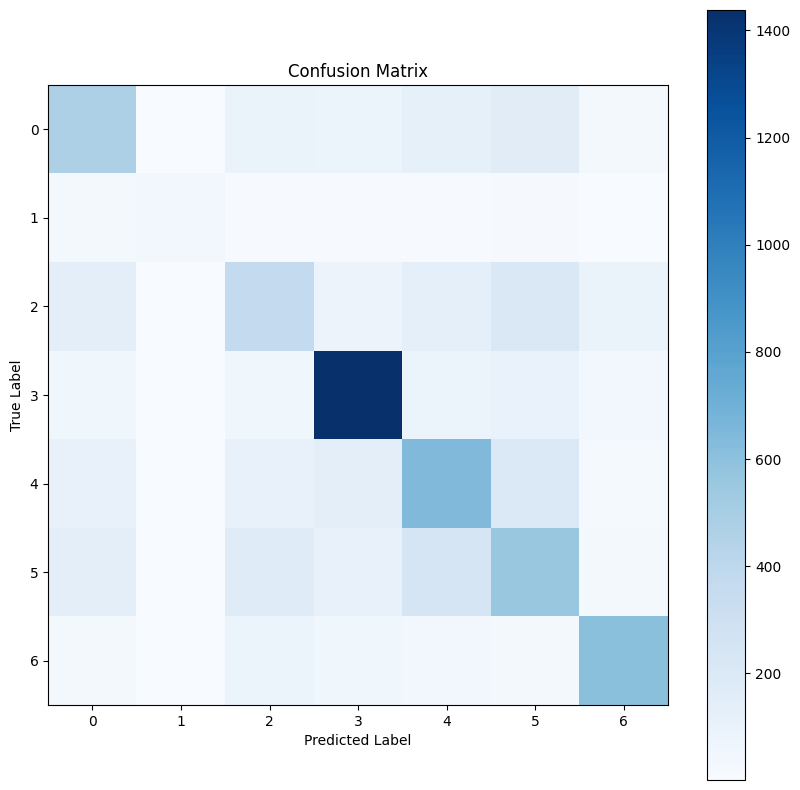

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print(cm)
# for x, y in zip(all_labels, all_preds):
#   print(x,y)

# Plot the confusion matrix
plt.figure(figsize=(10,10))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(7)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()